<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install Ta-Lib

In [ ]:
pip install Ta-Lib -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
pip install git+https://github.com/quantopian/pyfolio

In [ ]:
## install finrl library
!pip install wrds -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install swig -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git 


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [146]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
import torch
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
# matplotlib.use('Agg')
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
#from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_add import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../mha-gru-drl")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [149]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [151]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-02-28'

In [150]:
TRAIN_START_DATE = '2012-10-10'
TRAIN_END_DATE = '2020-02-28'
TRADE_START_DATE = '2020-03-01'
TRADE_END_DATE = '2021-02-28'


In [5]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [6]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [ ]:
df_index

In [7]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [15]:
#随机选择成分股中的k只股票
import random 
k = 10
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['600340.SH', '601857.SH', '600050.SH', '600837.SH', '600016.SH', '600036.SH', '601088.SH', '601186.SH', '600104.SH', '601211.SH']


In [23]:
selected_tics = ['600104.SH', '600050.SH','600048.SH','600036.SH', '600031.SH', '600030.SH', '600028.SH', '600016.SH','600009.SH', '600000.SH']

In [ ]:
#如果选择从config中配置可以用这段代码快速更改后缀
# new = []
# for c in config_tickers.SSE_50_TICKER:
#     c = c.replace('XSHG','SH')
#     new.append(c)
# print(new,len(new))

In [16]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date=TRAIN_START_DATE,end_date=TRADE_END_DATE)
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     600340.SH   20201231  12.86  13.04  12.76  12.93      12.80    0.13   
1     600340.SH   20201230  12.60  12.84  12.56  12.80      12.69    0.11   
2     600340.SH   20201229  12.52  12.83  12.42  12.69      12.53    0.16   
3     600340.SH   20201228  12.69  12.78  12.50  12.53      12.80   -0.27   
4     600340.SH   20201225  13.01  13.04  12.63  12.80      13.01   -0.21   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1341  601211.SH   20150702  35.80  35.88  31.35  31.42      34.82   -3.40   
1342  601211.SH   20150701  36.00  37.30  34.03  34.82      34.34    0.48   
1343  601211.SH   20150630  30.68  34.34  29.18  34.34      31.22    3.12   
1344  601211.SH   20150629  31.22  31.22  29.18  31.22      28.38    2.84   
1345  601211.SH   20150626  23.65  28.38  23.65  28.38      19.71    8.67   

      pct_chg         vol        amount  
0      1.0156    86334.06  1.1155

In [ ]:
df_ts = pd.read_csv('10_test_628.csv')

In [24]:
k=10

In [ ]:
df_ts.to_csv('10_test_628.csv',index=None)

In [ ]:
max_len = max(df_ts['ts_code'].value_counts())

In [ ]:
# #检验50只股票的信息缺省的时间点和个数
# dimatch_num = 0
# dimatch_date =[]
# for c in df_ts1['trade_date'].unique():
#     temp = df_ts1[df_ts1['trade_date'] == c]
#     if len(temp) != 50:
#         dimatch_num +=1
#         dimatch_date.append(c)
# print(dimatch_num,dimatch_date)

In [ ]:
# #获取SSE的交易日历
# import exchange_calendars as tc
# def get_trading_days(exchange: str, start_date: str, end_date: str):
#     days = pro.trade_cal(exchange=exchange, start_date=start_date, end_date=end_date)
#     days = days[days['is_open'] == 1]
#     full_date_range = pd.DataFrame({'trade_date':days['cal_date']})
#     full_date_range['trade_date'] = full_date_range['trade_date'].astype(str)
#     return full_date_range

# full_date_range = get_trading_days(exchange='SSE',start_date='20121010', end_date='20230228')
# print(full_date_range)

In [ ]:
# date_unique = df['date'].unique()
# date_sum = len(date_unique)
# count = 0
# for date in date_unique:
#     temp_df = df[df['trade_date'] == date]
# #     if len(temp_df) = k:
# #         count +=1
# #     elif len(temp_df) < int(0.9*k):
# #         date_unique.remove(date)
# #     else:
#     difference_tic = temp_df['ts_code'].tolist().difference(selected_tics)
#     missing_tic.append(date,difference_tic)

In [ ]:
# #遍历扩充股票的完整交易日期
# def add_exchange_calendars(df,full_date_range,selected_tics):
#     merge_df = []
#     for tic in selected_tics:
#         temp_df = df[df['ts_code'] == tic]
#         temp_full_date_range = full_date_range
#         temp_df = temp_df.set_index('trade_date')
#         temp_full_date_range = temp_full_date_range.set_index('trade_date')
#         temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
#         temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
#         temp_df = temp_df.fillna({
#             'amount' : 0,
#             'vol': 0,
#             'pct_chg': 0,
#             'change':0,
#             'ts_code': tic
#         })
#         for i in range(len(temp_df)):
#             if pd.isna(temp_df.loc[i,'close']):
#                 j = i -1
#                 while pd.isna(temp_df.loc[j,'close']):
#                     j = j - 1
#                 if j > 0 :
#                     temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
#         merge_df.append(temp_df)
#     merged_df = pd.concat(merge_df,ignore_index = True)
#     return merged_df

# merged_df =  add_exchange_calendars(df_ts,full_date_range,selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# print(merged_df)

In [ ]:
# 筛选exchange_calender中每个交易节点缺失情况
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) < int(0.9*k):
            date_unique.remove(date)
        elif len(temp_df) >= int(0.9*k) and len(temp_df) < k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
            print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':np.nan, 'high':np.nan,'low':np.nan, 'close':np.nan, 'pre_close':np.nan, 'change':np.nan, 'pct_chg':np.nan, 'volume':np.nan, 'amount':np.nan}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
#             print(len(temp_df))
            processe_df.append(temp_df)
        else :
            count += 1
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique


In [10]:
# 筛选exchange_calender中每个交易节点缺失情况(全部补充0)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) != k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
#             print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':0, 'high':0,'low':0, 'close':0, 'pre_close':0, 'change':0, 'pct_chg':0, 'volume':0, 'amount':0}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
            processe_df.append(temp_df)
        else :
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique

In [10]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique
        

In [17]:
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

         ts_code trade_date   open   high    low  close  pre_close  change  \
0      601211.SH   20150626  23.65  28.38  23.65  28.38      19.71    8.67   
1      600340.SH   20150626  28.80  29.89  26.99  26.99      29.99   -3.00   
2      601857.SH   20150626  11.15  11.37  10.27  10.53      11.32   -0.79   
3      600050.SH   20150626   7.50   7.69   7.02   7.02       7.80   -0.78   
4      600837.SH   20150626  22.98  24.20  21.23  21.28      23.59   -2.31   
...          ...        ...    ...    ...    ...    ...        ...     ...   
12135  600016.SH   20201231   5.17   5.22   5.15   5.20       5.17    0.03   
12136  600837.SH   20201231  12.53  13.03  12.50  12.86      12.49    0.37   
12137  600050.SH   20201231   4.43   4.48   4.43   4.46       4.45    0.01   
12138  601857.SH   20201231   4.13   4.16   4.12   4.15       4.13    0.02   
12139  600340.SH   20201231  12.86  13.04  12.76  12.93      12.80    0.13   

       pct_chg         vol       amount  
0      43.9900    206

In [18]:
# processed_df1 = processed_df.drop('volume',axis=1)
processed_df1 = processed_df.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'])
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600016.SH,2015-06-26,9.23,9.65,8.67,9.08,9.40,-0.32,-3.4000,7108734.30,6562867.866
1,600016.SH,2015-06-29,9.30,9.65,8.80,9.41,9.08,0.33,3.6300,9966281.94,9309568.058
2,600016.SH,2015-06-30,9.45,10.06,9.42,9.94,9.41,0.53,5.6300,9436895.05,9229600.781
3,600016.SH,2015-07-01,9.75,9.88,9.50,9.56,9.94,-0.38,-3.8200,6366894.11,6166608.503
4,600016.SH,2015-07-02,9.67,9.78,9.15,9.56,9.56,0.00,0.0000,6866770.09,6568562.550
...,...,...,...,...,...,...,...,...,...,...,...
12135,601857.SH,2020-12-25,4.15,4.18,4.14,4.17,4.16,0.01,0.2404,421830.70,175443.183
12136,601857.SH,2020-12-28,4.17,4.18,4.12,4.14,4.17,-0.03,-0.7194,759571.96,315104.362
12137,601857.SH,2020-12-29,4.14,4.16,4.10,4.13,4.14,-0.01,-0.2415,759610.09,313543.583
12138,601857.SH,2020-12-30,4.12,4.14,4.11,4.13,4.13,0.00,0.0000,500125.66,206322.494


In [19]:
def delaydate(dela,full_list):
    grouped = full_list.groupby('tic')
    filtered_df = pd.DataFrame()
    for name, group in grouped:
        # 按'trade_date'升序排序  True=升序
        group = group.sort_values('date', ascending=True)
        
        # 丢弃前'dela'个日期的数据
        group = group.iloc[dela:]
        filtered_df = filtered_df.append(group)
    
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df = filtered_df.sort_values(['tic','date'],ascending=True,ignore_index=True)
    return filtered_df

In [119]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

In [120]:
processed_df3 = processed_df1.rename(columns={'ts_code':'tic','trade_date':'date','vol':'volume'})

In [121]:
processed_df3 = fe.preprocess_data(processed_df3)
processed_df3 = processed_df3.fillna(method="ffill").fillna(method="bfill")

Successfully added technical indicators


In [122]:
processed_df3 = processed_df3.sort_values(['tic','date'],ascending=True).reset_index()

In [106]:
processed_df3

,index,tic,date,open,high,low,close,pre_close,change,pct_chg,...,amount,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,0,600016.SH,2015-06-26,9.23,9.65,8.67,9.08,9.40,-0.32,-3.4000,...,6562867.866,0.000000,9.711690,8.778310,100.000000,66.666667,100.000000,9.080000,9.080000,0.000000
1,10,600016.SH,2015-06-29,9.30,9.65,8.80,9.41,9.08,0.33,3.6300,...,9309568.058,0.007404,9.711690,8.778310,100.000000,66.666667,100.000000,9.245000,9.245000,0.000000
2,20,600016.SH,2015-06-30,9.45,10.06,9.42,9.94,9.41,0.53,5.6300,...,9229600.781,0.025869,10.344384,8.608949,100.000000,100.000000,100.000000,9.476667,9.476667,0.000000
3,30,600016.SH,2015-07-01,9.75,9.88,9.50,9.56,9.94,-0.38,-3.8200,...,6166608.503,0.019914,10.210872,8.784128,68.351795,52.489060,100.000000,9.497500,9.497500,0.000000
4,40,600016.SH,2015-07-02,9.67,9.78,9.15,9.56,9.56,0.00,0.0000,...,6568562.550,0.016259,10.130322,8.889678,68.351795,15.927476,1.241999,9.510000,9.510000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12135,12099,601857.SH,2020-12-25,4.15,4.18,4.14,4.17,4.16,0.01,0.2404,...,175443.183,-0.016510,4.337491,4.099509,46.568380,-105.736396,1.044924,4.239333,4.181833,7.225363
12136,12109,601857.SH,2020-12-28,4.17,4.18,4.12,4.14,4.17,-0.03,-0.7194,...,315104.362,-0.019266,4.325713,4.094287,44.854045,-110.445746,3.672444,4.235667,4.182667,31.079908
12137,12119,601857.SH,2020-12-29,4.14,4.16,4.10,4.13,4.14,-0.01,-0.2415,...,313543.583,-0.022005,4.314316,4.088684,44.291795,-124.635367,8.251218,4.230667,4.183167,17.105730
12138,12129,601857.SH,2020-12-30,4.12,4.14,4.11,4.13,4.13,0.00,0.0000,...,206322.494,-0.023899,4.300037,4.085963,44.291795,-117.164531,8.251218,4.226333,4.183833,3.394955


In [ ]:
# #对于第二次任务训练任务—————强化学习决策任务
# import datetime

# start_date = datetime.datetime.strptime(TRAIN_START_DATE, '%Y-%m-%d')
# timestep = datetime.timedelta(days=48) # 这里需要验证48是否是已有数据往前推，还是只在时间维度向前推48天，可能会存在不足48天数据的情况。
# target_date = start_date - timestep
# train_df = processed_df1[processed_df1['trade_date'] <= TRAIN_END_DATE]
# backtest_df = processed_df1[(processed_df1['trade_date'] >= target_date) & (processed_df1['trade_date'] <= TRADE_END_DATE)]
# print('target_date:',target_date,'train_df:',train_df,'backtest_df:',backtest_df)


In [28]:
processed_df2

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,...,close_30_sma_x,close_60_sma_x,macd_y,boll_ub_y,boll_lb_y,rsi_30_y,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y
0,600000.SH,2012-01-04,8.54,8.56,8.39,8.41,8.49,-0.08,-0.9400,342013.79,...,8.410000,8.410000,0.000000,8.869411,8.190589,100.000000,66.666667,100.000000,8.410000,8.410000
2214,600009.SH,2012-01-04,12.34,12.36,12.04,12.09,12.24,-0.15,-1.2300,27758.87,...,12.090000,12.090000,0.000000,8.869411,8.190589,100.000000,66.666667,100.000000,12.090000,12.090000
4428,600016.SH,2012-01-04,5.95,5.96,5.85,5.86,5.89,-0.03,-0.5100,705268.71,...,5.860000,5.860000,0.000000,8.869411,8.190589,100.000000,66.666667,100.000000,5.860000,5.860000
6642,600028.SH,2012-01-04,7.28,7.44,7.27,7.36,7.18,0.18,2.5100,528181.38,...,7.360000,7.360000,0.000000,8.869411,8.190589,100.000000,66.666667,100.000000,7.360000,7.360000
8856,600030.SH,2012-01-04,9.79,9.85,9.56,9.56,9.71,-0.15,-1.5400,354005.33,...,9.560000,9.560000,0.000000,8.869411,8.190589,100.000000,66.666667,100.000000,9.560000,9.560000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13283,600031.SH,2021-12-31,23.18,23.27,22.72,22.80,23.14,-0.34,-1.4693,977086.70,...,23.110667,23.329667,0.030926,24.283460,22.691540,45.452846,-17.980785,1.424831,23.110667,23.329667
15497,600036.SH,2021-12-31,48.54,48.88,48.33,48.71,48.50,0.21,0.4330,492935.01,...,50.740000,51.756167,-0.805103,53.755854,47.650146,43.338101,-130.943525,34.653738,50.740000,51.756167
17711,600048.SH,2021-12-31,15.06,15.88,15.05,15.63,15.10,0.53,3.5099,654052.40,...,14.743000,14.091333,0.317699,15.941564,14.041436,58.334595,122.617625,37.467764,14.743000,14.091333
19925,600050.SH,2021-12-31,3.93,3.94,3.91,3.93,3.92,0.01,0.2551,753942.78,...,3.929333,4.007833,-0.012038,3.970836,3.899164,43.005771,-13.294503,18.587572,3.929333,4.007833


In [25]:
pro_df = processed_df1.loc[:,['open','high','low','close','vol']].reset_index(drop=True)

In [20]:
pro_df

,open,high,low,close,vol
0,8.54,8.56,8.39,8.41,342013.79
1,8.47,8.82,8.47,8.65,1321162.03
2,8.63,8.78,8.62,8.71,617786.87
3,8.72,8.99,8.68,8.95,801362.49
4,8.95,9.10,8.88,9.07,720046.32
...,...,...,...,...,...
22135,20.60,20.83,20.58,20.81,191549.63
22136,20.84,21.01,20.67,20.84,265709.63
22137,20.83,20.84,20.42,20.59,275013.58
22138,20.55,20.74,20.49,20.53,217608.16


In [ ]:
#出现缺失值的个数、占比
count = len(pro_df[pro_df['open'] == 0])
nan_rate = count/len(pro_df)
print(count,'缺失值百分之:',nan_rate)

In [26]:
#计算技术指标到dataset中
#Can be easily expanded
#Currently contains a small set of tech indicators
import talib as ta

def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["close"])
    data['dema'] = ta.DEMA(data["close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["close"], timeperiod=30)
    data['ema'] = ta.EMA(data["close"], timeperiod=30)
    data['wma'] = ta.WMA(data["close"], timeperiod=30)
    data['sma'] = ta.SMA(data["close"], timeperiod=30)
    data['sarext'] = ta.SAREXT(data["high"], data["low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["high"], data["low"], data["close"], timeperiod=14)
    data['apo'] = ta.APO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["high"], data["low"], timeperiod=14)
    data['cci'] = ta.CCI(data["high"], data["low"], data["close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["high"], data["low"], data["close"], data['vol'], timeperiod=14)
    data['mom'] = ta.MOM(data["close"], timeperiod=10)
    data['plus_di'] = ta.PLUS_DI(data["high"], data["low"], data["close"], timeperiod=14)
    data['ppo'] = ta.PPO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['roc'] = ta.ROC(data["close"], timeperiod=10)
    data['rocp'] = ta.ROCP(data["close"], timeperiod=10)
    data['rsi'] = ta.RSI(data["close"], timeperiod=14)
    data['slowk'], data['slowd'] = ta.STOCH(data["high"], data["low"], data["close"])
    data['fastk'], data['fastd'] = ta.STOCHF(data["high"], data["low"], data["close"])
    data['trix'] = ta.TRIX(data["close"], timeperiod=30)
    data['ultosc'] = ta.ULTOSC(data["high"], data["low"], data["close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    data['willr'] = ta.WILLR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["high"], data["low"], data["close"], data['vol'])
    data['obv'] = ta.OBV(data["close"], data['vol'])
    
    #volitility
    data['atr'] = ta.ATR(data["high"], data["low"], data["close"], timeperiod=14)
    data['natr'] = ta.NATR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["close"])
#     data['HT_DCPHASE'] = ta.HT_DCPHASE(data["close"])
#     data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["close"])
    
    
    return data

In [27]:
full_list1 = calc_tech_ind(pro_df)
full_list1 = full_list1.fillna(0)

In [ ]:
full_list1

In [ ]:
full_list2 = calc_tech_ind(backtest_df_reduction)
full_list2 = full_list2.fillna(0)

In [28]:
array_full_list = np.array(full_list1)
array_full_list = array_full_list.reshape(k,int(len(full_list1)/k),full_list1.shape[1])
selected_tics = sorted(selected_tics)

In [ ]:
array_full_list2 = np.array(full_list2)
array_full_list2 = array_full_list2.reshape(k,int(len(full_list2)/k),full_list2.shape[1])

In [ ]:
np.isnan(array_full_list).any()

In [ ]:
#text
# tdata = array_full_list[0][:-1]
ttdata = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
windows = 5
gap = 1
batch_size = 3
start = len(ttdata) - windows
test_list = []
while start >= 0:
#     print(ttdata[start:start + windows - 1],ttdata[start + windows-1])
    segdata = ttdata[start:start + windows]
#     segclose = ttdata[start:start + windows]
    test_list.extend([segdata] * batch_size)
#     test_list.append(segdata)
    start = start - gap
    print(test_list,'hhhhhhhhhhhhhhh',segdata)
    
# print(np.array(test_list)[::-1])

In [ ]:
# #generate x, y, z, zp quadruples
# #segment x, y, z trios to sequence according to $timeStep and $gap
# #x: historical data w/ technical analysis indicator
# #y: closing price of t+1
# #z:  difference between t+1 and t step's closing price

# def toSequential(idx, full_list, timeStep=48, gap=4):
#     #closing: from id=0 to last
#     closing=full_list[idx][:, 3]
#     #data from id=0 to second to last
#     data=full_list[idx][:-1]
#     #calculating number of available sequential samples
#     data_length=len(data)
#     count=(data_length-timeStep)//gap+1
#     stockSeq=[]
#     labelSeq=[]
#     diffSeq=[]
#     realDiffSeq=[]
    
#     start = data_length - timeStep
#     while start >= 0:
#         segData = data[start:start + timeStep - 1]
#         segClosing = closing[start:start + timeStep]
#         std_dev = segData.std(axis=0, keepdims=True)
#         std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#         std_dev_close = segClosing.std()
#         std_dev_close_nonzero = np.where(std_dev_close == 0, 1, std_dev_close)
#         segClosingNorm=(segClosing-segClosing.mean())/std_dev_close_nonzero
#         stockSeq.append(segDataNorm)
#         labelSeq.append(segClosingNorm[1:])
# #         print(np.isnan(labelSeq).any())
#         diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
#         realDiffSeq.append(segClosing[1:]-segClosing[:-1])       
#         start = start - gap
#     stockSeq=np.array(stockSeq)[::-1]
#     labelSeq=np.array(labelSeq)[::-1]
#     diffSeq=np.array(diffSeq)[::-1]
#     realDiffSeq=np.array(realDiffSeq)[::-1]
    
#     return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

# Dataloader的构建

In [29]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train1(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
#     closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
    
        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [30]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[0,]
    realDiffSeq=[0,]
    for i in range(count-1):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closingNorm[gap*i+timeStep]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#       segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
#       segClosingNorm=(segClosing-segClosing.mean())/segClosing.std()
        #segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosing)
        diffSeq.append(segClosing-diffSeq[-1])
        realDiffSeq.append(closing[gap*i+timeStep]-realDiffSeq[-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [31]:
def toSequential_back(idx, full_list, timeStep = 48, gap = 1,batch_size = 64):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    start = data_length - timeStep
    i=0
    while start >= 0:
        segData = data[start:start + timeStep]
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        #复制batch_size个
        stockSeq.extend([segDataNorm] * batch_size)
#         stockSeq.append(segDataNorm)   
        start = start - gap
        i +=1
    stockSeq=np.array(stockSeq)[::-1]
#     print(i)
    return stockSeq.astype('float32')

In [32]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=3):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        closing_cohort=[]
        diff_cohort=[]
        real_diff_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X, y, z, zp=toSequential_train1(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
            closing_cohort.append(y)
            diff_cohort.append(z)
            real_diff_cohort.append(zp)
        self.X=np.concatenate(stock_cohort, axis=0)
        self.y=np.concatenate(closing_cohort, axis=0)
        self.z=np.concatenate(diff_cohort, axis=0)  
        self.zp=np.concatenate(real_diff_cohort, axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    
    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [33]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_back(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=1):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X=toSequential_back(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
        self.X=np.concatenate(stock_cohort, axis=0)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        if self.transform:
            data=self.transform(data)
        return data
        
    def getDS(self):
        return self.X

In [34]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False):
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        all_ids = list(range(name_count))
        train_id_list = list(set(all_ids) - set(test_id_list) - set(val_id_list))
#         partial_list=full_list[train_list,:,:]
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        train_iter=DataLoader(StockDataset(train_id_list, full_list), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {[name_list[train_id] for train_id in train_id_list]} ')
        return train_iter, val_iter, test_iter

In [35]:
train_iter, val_iter, test_iter = DataIterGen([3],[4],selected_tics,array_full_list)

Val: ['600340.SH'], Test: ['600104.SH'], Train: ['600016.SH', '600036.SH', '600050.SH', '600837.SH', '601088.SH', '601186.SH', '601211.SH', '601857.SH'] 


In [ ]:
len(array_full_list[0][0])

In [ ]:
for x,y,z,zp in train_iter: # x shape (bs,timestep,features); y、z、zp、shape(bs)
    print(len(y),x)

# Transformer

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_size, d_model, d_ff, num_heads,env_size, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encode = Encoder(d_model, d_ff, num_heads, num_layers)
        self.linear1 = nn.Linear(d_model, env_size)
        self.rule = nn.ReLU()
        self.linear2 = nn.Linear(env_size,1)
        

    def forward(self, x):
        x = self.embedding(x)
#         print(x.shape)
        x = x.permute(1,0,2)
        encoded = self.encode(x)
        encoded = self.linear1(encoded)
        x = self.rule(encoded)
        x = self.linear2(x)
#         print(x.shape)
        decoded = x.permute(1,0,2)
        return decoded, encoded.permute(1,0,2)[0,-1,:]  


In [37]:
class Encoder(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, num_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, num_heads):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x  # 保存输入的残差连接

        # Self-Attention
        x, _ = self.self_attention(x, x, x)
        x = x + residual  # 残差连接
        x = self.norm1(x)  # Add & Norm

        residual = x  # 保存 Self-Attention 后的残差连接

        # Feed-Forward
        x = self.feed_forward(x)
        x = x + residual  # 残差连接
        x = self.norm2(x)  # Add & Norm

        return x

In [39]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [40]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        for X, y, z, zp in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred,enVec = model(inputs)
            enVec_list.append(enVec)
#             print(pred,targets)
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
    return enVec_list
# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y, z, zp in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [41]:
def predict(model,back_iter):
    enVec_list = []
    with torch.no_grad():
        for X in back_iter:
            inputs = X.to(device)
            _,enVec = model(inputs)
            enVec_list.append(enVec)
    return enVec_list

In [ ]:
for X, y, z, zp in back_iter:
    print(len(X[0]),X)

In [42]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device=try_gpu()

In [43]:
# 定义模型
model = Transformer(input_size = 42, d_model = 128 , num_layers = 2, d_ff = 512 ,num_heads = 8,env_size =40)
optimizer = optim.Adam(model.parameters(), lr=0.001)
outcoming =train(model,train_iter,optimizer,5)
valtest =val(model,val_iter)

Epoch 1: Loss: 0.2568
Epoch 2: Loss: 0.1768
Epoch 3: Loss: 0.1383
Epoch 4: Loss: 0.0954
Epoch 5: Loss: 0.0615
val Loss: 0.0728


In [ ]:
back_iter = DataLoader(StockDataset_back([i for i in range(k)],array_full_list), shuffle=False, batch_size=64, num_workers=0,drop_last=False)

In [44]:
# feature_enginner
alltic_list = [i for i in range(k)]

def Feature_enginner(model, processed_df, full_list, alltic_list, batch_size=64, k=15, env_size=40,dela = 48):
    back_iter = DataLoader(StockDataset_back([i for i in range(k)],full_list), shuffle=False, batch_size=batch_size, num_workers=0,drop_last=False)
    
    new_state = predict(model,back_iter)
    concatenated_tensor = torch.cat(new_state, dim=0)
    concatenated_tensor = concatenated_tensor.view(-1,env_size)
    feature_df = pd.DataFrame(concatenated_tensor.numpy())
    
    full_delay_df = delaydate(dela ,processed_df)
    
    merged_df = pd.concat([full_delay_df, feature_df], axis=1)
    merged_df = merged_df.loc[:,['tic','date','close'] + INDICATORS + [i for i in range(env_size)]]
    merged_df.columns = ['tic','date','close'] + INDICATORS + [f"temporal_feature_{i}" for i in range(env_size)]
    return merged_df

In [43]:
processed_df3.columns

Index(['index', 'tic', 'date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'volume', 'amount', 'macd', 'boll_ub', 'boll_lb',
       'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'],
      dtype='object')

In [61]:
full_delay_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600000.SH,2012-03-21,9.18,9.19,9.02,9.08,9.12,-0.04,-0.4400,518670.60,471579.975
1,600000.SH,2012-03-22,9.09,9.21,9.03,9.12,9.08,0.04,0.4400,386511.97,352251.184
2,600000.SH,2012-03-27,9.15,9.17,9.08,9.12,9.13,-0.01,-0.1100,272946.40,249025.233
3,600000.SH,2012-03-28,9.12,9.14,8.93,8.97,9.12,-0.15,-1.6400,435653.07,394701.420
4,600000.SH,2012-03-29,8.94,9.00,8.85,8.87,8.97,-0.10,-1.1100,483914.15,432068.893
...,...,...,...,...,...,...,...,...,...,...,...
21655,600104.SH,2021-12-27,20.60,20.83,20.58,20.81,20.59,0.22,1.0685,191549.63,397692.117
21656,600104.SH,2021-12-28,20.84,21.01,20.67,20.84,20.81,0.03,0.1442,265709.63,552626.350
21657,600104.SH,2021-12-29,20.83,20.84,20.42,20.59,20.84,-0.25,-1.1996,275013.58,565047.437
21658,600104.SH,2021-12-30,20.55,20.74,20.49,20.53,20.59,-0.06,-0.2914,217608.16,448240.033


In [45]:
addfeature_df = Feature_enginner(model, processed_df3, array_full_list, alltic_list, batch_size=64, k=10 ,env_size=40, dela=48)

In [82]:
addfeature_df1 = addfeature_df.loc[:,['tic','date','close'] + INDICATORS + [i for i in range(40)]]

In [83]:
addfeature_df1.columns = ['tic','date','close'] + INDICATORS + [f"temporal_feature_{i}" for i in range(40)]

In [46]:
addfeature_df

,tic,date,close,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,...,temporal_feature_30,temporal_feature_31,temporal_feature_32,temporal_feature_33,temporal_feature_34,temporal_feature_35,temporal_feature_36,temporal_feature_37,temporal_feature_38,temporal_feature_39
0,600016.SH,2015-09-11,8.59,-0.126071,9.473997,7.629003,46.992412,-30.763798,10.110370,8.796000,...,-0.075469,0.207814,1.152828,0.065785,0.089696,-0.551923,0.748759,-0.535022,-0.227007,-0.431453
1,600016.SH,2015-09-14,9.08,-0.076875,9.466967,7.632033,51.278779,14.518101,10.535119,8.797000,...,-0.173043,0.093598,1.148325,-0.232124,-0.021538,-0.586259,0.665937,-0.636534,-0.247242,-0.441909
2,600016.SH,2015-09-15,9.04,-0.040596,9.463665,7.633335,50.930986,30.514746,10.535119,8.795333,...,-0.219055,-0.081940,0.819109,-0.705156,-0.269138,-0.423965,0.718917,-0.683382,-0.156207,-0.201573
3,600016.SH,2015-09-16,8.98,-0.016422,9.466600,7.632400,50.400551,37.072215,13.238932,8.783333,...,-0.282241,-0.363008,0.444607,-0.996756,-0.280831,-0.199805,0.686584,-0.832400,-0.308491,-0.212950
4,600016.SH,2015-09-17,8.76,-0.014573,9.471212,7.632788,48.485174,21.520405,8.422666,8.760333,...,-0.387508,-0.599116,0.279459,-1.237950,-0.223653,-0.152773,0.797669,-1.038980,-0.491542,-0.338175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,601857.SH,2020-12-25,4.17,-0.016510,4.337491,4.099509,46.568380,-105.736396,1.044924,4.239333,...,0.079556,0.308186,1.363455,-0.582439,0.466332,-1.209382,0.328300,-1.056315,-0.068866,-0.857726
11656,601857.SH,2020-12-28,4.14,-0.019266,4.325713,4.094287,44.854045,-110.445746,3.672444,4.235667,...,0.032131,0.133558,1.312536,-0.800657,0.470009,-1.063835,0.293127,-1.312407,0.019379,-0.757189
11657,601857.SH,2020-12-29,4.13,-0.022005,4.314316,4.088684,44.291795,-124.635367,8.251218,4.230667,...,-0.324891,0.134117,1.338132,-0.523744,0.870820,-1.070701,0.265602,-1.412701,-0.125826,-0.612695
11658,601857.SH,2020-12-30,4.13,-0.023899,4.300037,4.085963,44.291795,-117.164531,8.251218,4.226333,...,-0.424876,0.129752,1.537725,-0.249465,1.132307,-1.106698,0.419773,-1.362168,-0.244899,-0.610291


In [85]:
addfeature_df1.to_csv('629_test.csv',index=None)

In [5]:
addfeature_df1 = pd.read_csv('629_test.csv')

In [182]:
processed_df3.to_csv('630_processed.csv',index=None)

In [6]:
processed_df3 = pd.read_csv('630_processed.csv')

In [ ]:
torch.triu(g,diagonal=1+3)

In [ ]:
torch.triu(g,diagonal=1)

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [83]:
TRAIN_START_DATE = addfeature_df['date'].unique()[0]

In [152]:
train = data_split(processed_df3, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_df3, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

10060
2070


In [155]:
train = data_split(addfeature_df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(addfeature_df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

9580
2070


In [9]:
TRADE_START_DATE

'2020-03-01'

In [ ]:
train.tail(10)

In [50]:
selfattn_indicator_list = [f"temporal_feature_{i}" for i in range(40)]

In [ ]:
selfattn_indicator_list

In [ ]:
trade.head()

In [ ]:
INDICATORS

In [108]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 10, State Space: 101


In [156]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(selfattn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 10, State Space: 501


In [158]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1,
    'attn_indicator_list':selfattn_indicator_list
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [159]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [160]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True


In [ ]:
import torch
device = torch.device("mps")

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [45]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [161]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [162]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=30000) if if_using_ppo else None

---------------------------------
| time/              |          |
|    fps             | 786      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 545.7012 |
---------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 780         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006430668 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 3.9e+07     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000933   |
|    reward           

-----------------------------------------
| time/                   |             |
|    fps                  | 764         |
|    iterations           | 11          |
|    time_elapsed         | 29          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.005186497 |
|    clip_fraction        | 0.0145      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 6.82e+07    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00253    |
|    reward               | -539.7082   |
|    std                  | 1.01        |
|    value_loss           | 1.36e+08    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 763         |
|    iterations           | 12    

### Agent 4: TD3

In [64]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [65]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

day: 1724, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 1574649.96
total_reward: 574649.96
total_cost: 999.00
total_trades: 6896
Sharpe: 0.367
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 141       |
|    time_elapsed    | 48        |
|    total_timesteps | 6900      |
| train/             |           |
|    actor_loss      | -1.79e+03 |
|    critic_loss     | 1.21e+09  |
|    learning_rate   | 0.001     |
|    n_updates       | 5175      |
|    reward          | 21257.8   |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 127      |
|    time_elapsed    | 107      |
|    total_timesteps | 13800    |
| train/             |          |
|    actor_loss      | -7.6e+03 |
|    critic_loss     | 1.24e+09 |
|    learning_rate   | 0.001    |
|    n_updates       | 12075    |
|    reward   

### Agent 5: SAC

In [167]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [168]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 110       |
|    time_elapsed    | 34        |
|    total_timesteps | 3832      |
| train/             |           |
|    actor_loss      | -3.22e+03 |
|    critic_loss     | 2.33e+08  |
|    ent_coef        | 0.138     |
|    ent_coef_loss   | 185       |
|    learning_rate   | 0.0001    |
|    n_updates       | 3731      |
|    reward          | -11000.62 |
----------------------------------
day: 957, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 1101605.98
total_reward: 101605.98
total_cost: 999.00
total_trades: 2871
Sharpe: 0.225
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 109       |
|    time_elapsed    | 69        |
|    total_timesteps | 7664      |
| train/             |           |
|    actor_loss      | -66.2     |
|    critic_loss     | 1.95e+08  |
|   

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [113]:
data_risk_indicator = processed_df3[(processed_df3.date<TRAIN_END_DATE) & (processed_df3.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

In [ ]:
insample_risk_indicator.turbulence.describe()

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [169]:
e_trade_gym = StockTradingEnv(df = trade,**env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [115]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='turbulence', **env_kwargs)

In [87]:
trade

,index,tic,date,open,high,low,close,pre_close,change,pct_chg,...,close_60_sma_x,macd_y,boll_ub_y,boll_lb_y,rsi_30_y,cci_30_y,dx_30_y,close_30_sma_y,close_60_sma_y,turbulence
0,1007,600016.SH,2020-03-02,5.74,5.82,5.73,5.81,5.72,0.09,1.5734,...,6.122000,-0.083875,5.974980,5.762020,41.506319,-70.400699,45.184916,5.987000,6.122000,67.545752
0,2221,600036.SH,2020-03-02,34.24,34.88,34.10,34.75,34.20,0.55,1.6082,...,36.841167,-0.611881,36.290837,34.385163,43.150193,-82.266424,35.594191,36.148000,36.841167,67.545752
0,3435,600050.SH,2020-03-02,5.53,5.75,5.50,5.70,5.48,0.22,4.0146,...,5.720667,0.004751,5.931712,5.100288,49.698173,5.687343,16.882806,5.637333,5.720667,67.545752
0,4649,600104.SH,2020-03-02,22.32,23.63,22.28,23.20,22.21,0.99,4.4575,...,23.210000,0.074173,24.446554,20.108446,50.514521,22.185750,7.492301,22.783000,23.210000,67.545752
0,5863,600340.SH,2020-03-02,23.61,24.48,23.61,24.31,23.59,0.72,3.0521,...,26.477333,-0.568037,25.397495,23.171505,41.581017,-47.282044,32.292428,25.171667,26.477333,67.545752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,7283,600837.SH,2020-12-31,12.53,13.03,12.50,12.86,12.49,0.37,2.9624,...,13.700833,-0.258621,13.322500,12.145500,43.640341,-31.246779,1.011227,13.008667,13.700833,4.383849
206,8497,601088.SH,2020-12-31,18.04,18.11,17.79,18.01,18.03,-0.02,-0.1109,...,17.802833,-0.017124,19.146039,17.380961,51.136388,-74.696465,4.891039,18.496000,17.802833,4.383849
206,9711,601186.SH,2020-12-31,7.83,7.93,7.83,7.90,7.83,0.07,0.8940,...,8.351667,-0.151132,8.540151,7.729849,38.336722,-117.321853,24.912570,8.282000,8.351667,4.383849
206,10925,601211.SH,2020-12-31,17.21,17.74,17.19,17.53,17.14,0.39,2.2754,...,18.273667,-0.339469,18.769532,16.668468,44.986717,-67.615456,4.512393,18.095000,18.273667,4.383849


In [ ]:
trade.head()

In [170]:
trained_moedl = trained_sac
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [111]:
df_account_value.shape

(22, 2)

In [ ]:
df_account_value.tail()

In [110]:
df_actions.head()

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH
date,,,,,,,,,,
2021-11-01,0,19,0,0,0,0,8,0,5,9
2021-11-02,0,19,0,0,0,0,8,0,5,9
2021-11-03,0,19,0,0,0,0,8,0,5,9
2021-11-04,0,19,0,0,0,0,8,0,5,9
2021-11-05,0,19,0,0,0,0,8,0,5,9


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [145]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.107562
Cumulative returns     0.087540
Annual volatility      0.164473
Sharpe ratio           0.705692
Calmar ratio           1.097222
Stability              0.677468
Max drawdown          -0.098031
Omega ratio            1.139251
Sortino ratio          1.137172
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.360316
Daily value at risk   -0.020261
dtype: float64


In [171]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.059809
Cumulative returns     0.048872
Annual volatility      0.150374
Sharpe ratio           0.462817
Calmar ratio           0.489719
Stability              0.547728
Max drawdown          -0.122129
Omega ratio            1.097487
Sortino ratio          0.713576
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.157110
Daily value at risk   -0.018669
dtype: float64


In [60]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

         tic      date     weight
0  600016.SH  20200228  14.347826
1  600036.SH  20200228  35.652174
2  600050.SH  20200228   5.156076
3  600104.SH  20200228   7.865106
4  600340.SH  20200228   2.876254
5  600837.SH  20200228  11.622074
6  601088.SH  20200228   5.334448
7  601186.SH  20200228   4.420290
8  601211.SH  20200228   7.748049
9  601857.SH  20200228   4.977703


In [62]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
#     baseline['date'] = pd.to_datetime(baseline['date'],format='%Y%m%d')
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
# subset_df = addfeature_df.loc[(addfeature_df['date'].astype(str) >='20210301') & (addfeature_df['date'].astype(str)<='20220227')]
full_date_range1 = pd.DataFrame({'date':df_account_value['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(addfeature_df,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2020-03-02,2077.725084
1,2020-03-03,2077.743311
2,2020-03-04,2097.352564
3,2020-03-05,2160.686009
4,2020-03-06,2108.188294
...,...,...
202,2020-12-25,2276.679320
203,2020-12-28,2302.233445
204,2020-12-29,2276.694928
205,2020-12-30,2290.062319


In [ ]:
addfeature_df

In [ ]:
baseline_sse.info()

In [ ]:
# baseline_sse = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
# baseline_sse = baseline_sse.rename(columns={'trade_date':'date'})
# baseline_sse = baseline_sse.sort_values('date',ascending=True)
# print(baseline_sse)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')


In [ ]:
df_account_value

<a id='6.2'></a>
## 7.2 BackTestPlot

In [63]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2020-03-02
End date,2020-12-31
Total months,9
,Backtest
Annual return,5.981%
Cumulative returns,4.887%
Annual volatility,15.037%
Sharpe ratio,0.46
Calmar ratio,0.49
Stability,0.55
Max drawdown,-12.213%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.21,2020-11-09,2020-12-22,NaT,NaN
1,4.45,2020-07-14,2020-07-28,2020-10-13,66
2,2.45,2020-03-05,2020-06-15,2020-07-03,87
3,1.77,2020-10-21,2020-10-27,2020-10-29,7
4,1.43,2020-07-06,2020-07-10,2020-07-14,7


Stress Events,mean,min,max
New Normal,0.03%,-3.83%,4.44%


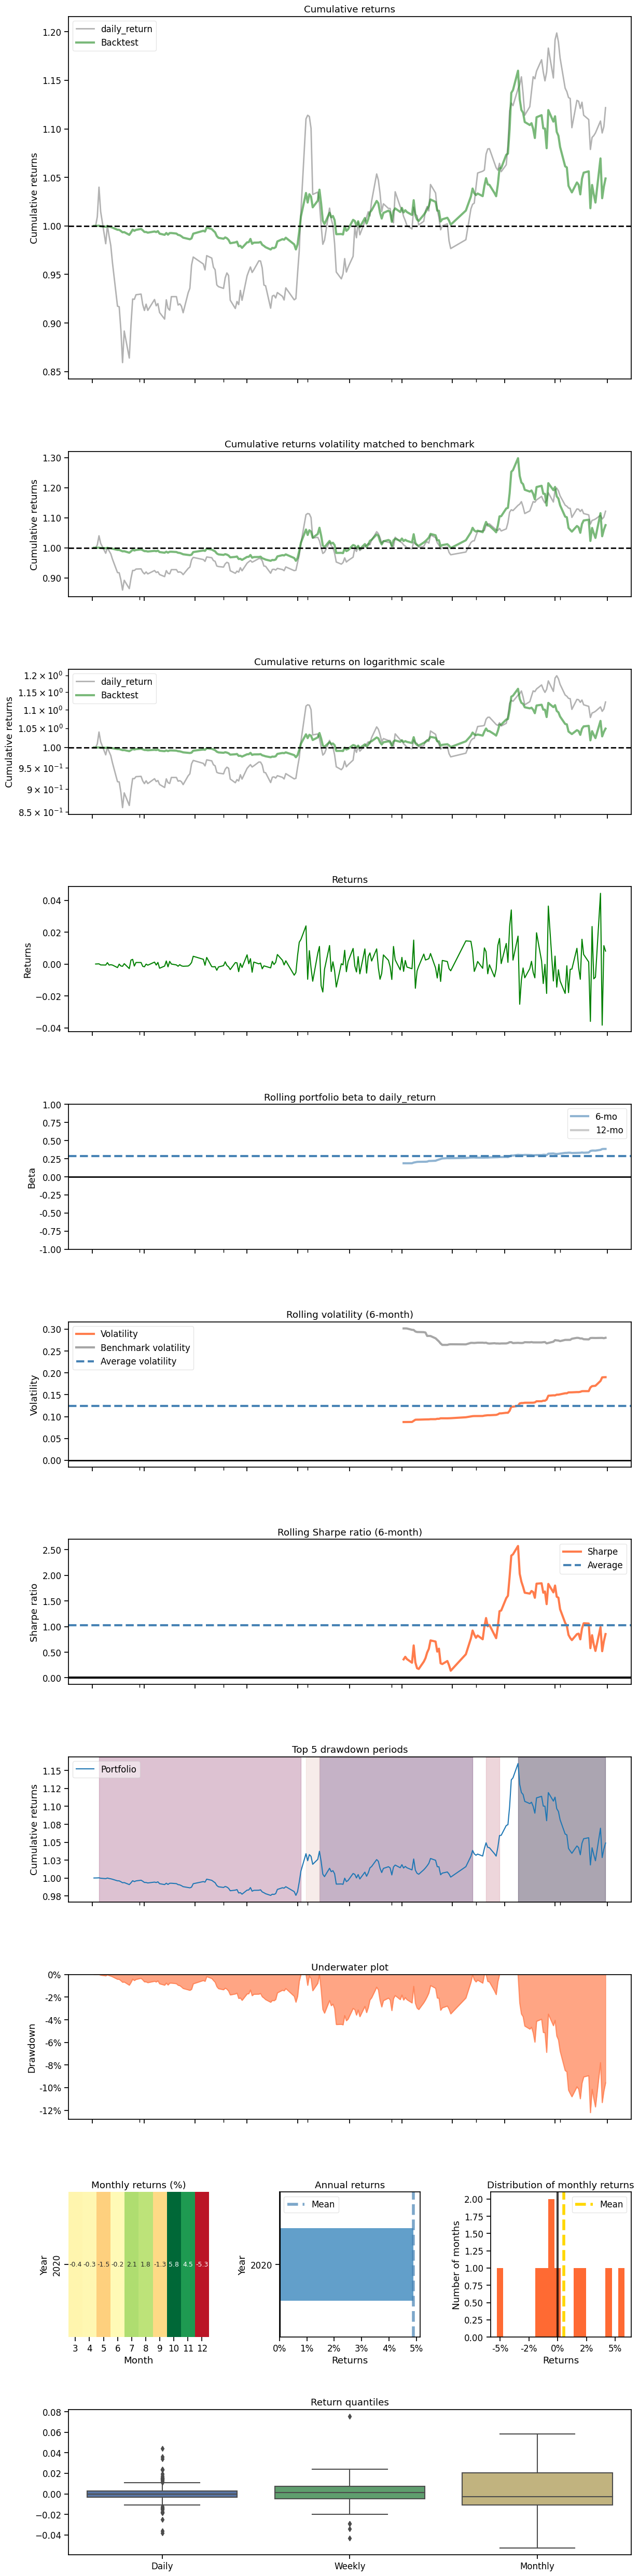

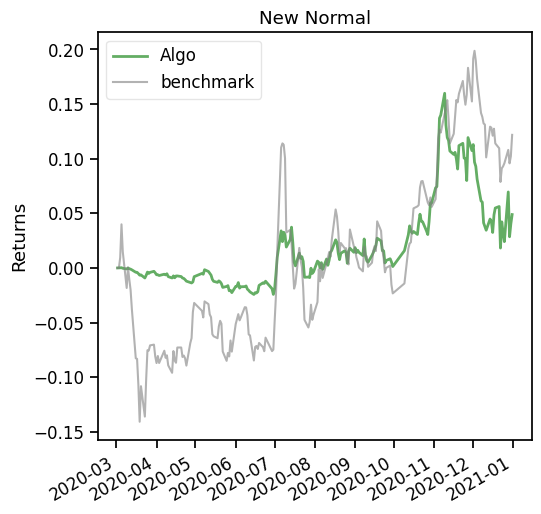

In [172]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

==============Compare to SSE50===========


Start date,2020-03-02
End date,2020-12-31
Total months,9
,Backtest
Annual return,0.355%
Cumulative returns,0.292%
Annual volatility,0.681%
Sharpe ratio,0.53
Calmar ratio,0.56
Stability,0.56
Max drawdown,-0.629%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.63,2020-12-02,2020-12-22,NaT,NaN
1,0.18,2020-08-17,2020-09-30,2020-10-16,45
2,0.18,2020-11-11,2020-11-13,2020-11-19,7
3,0.15,2020-04-30,2020-05-25,2020-06-08,28
4,0.15,2020-11-27,2020-11-30,2020-12-01,3


Stress Events,mean,min,max
New Normal,0.00%,-0.17%,0.21%


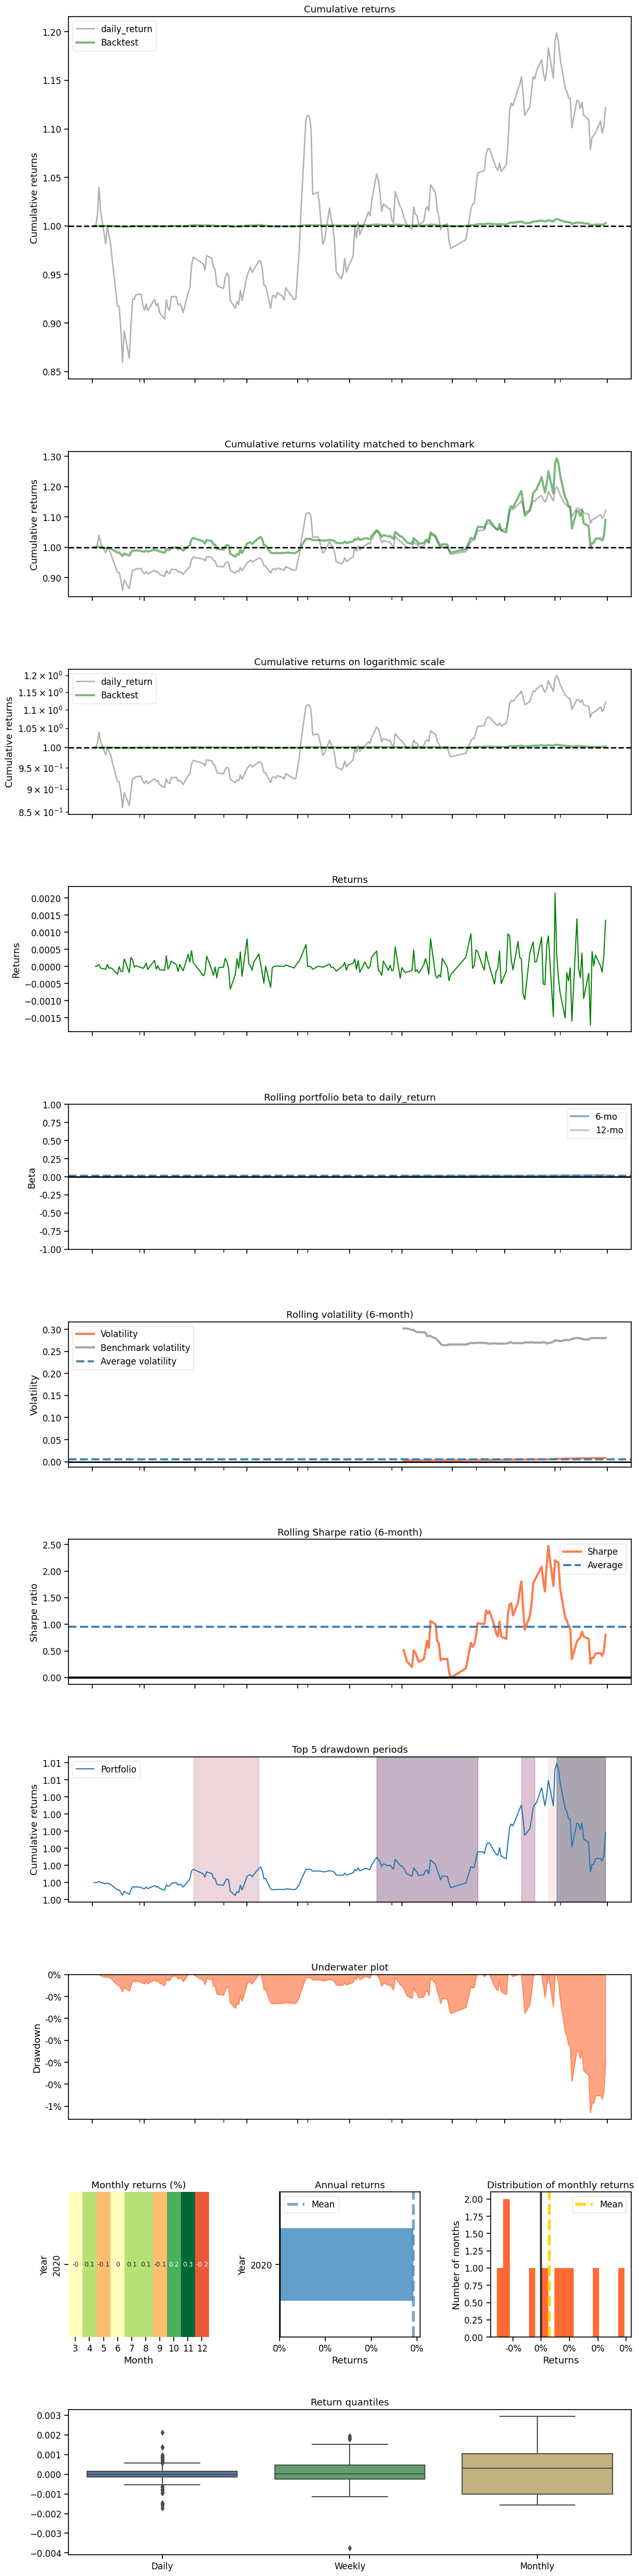

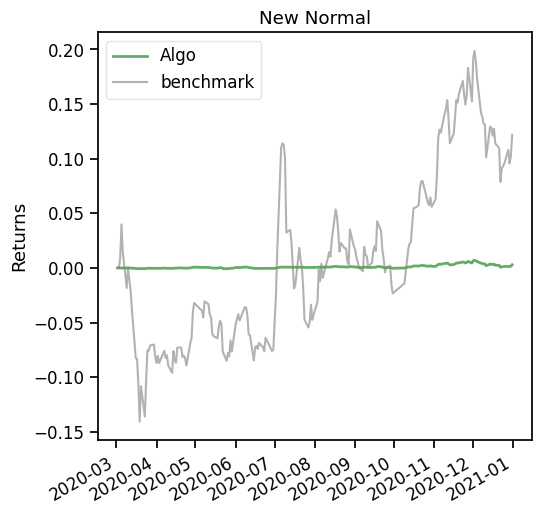

In [118]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

==============Compare to SSE50===========


Start date,2020-03-02
End date,2020-12-31
Total months,9
,Backtest
Annual return,10.766%
Cumulative returns,8.762%
Annual volatility,16.448%
Sharpe ratio,0.71
Calmar ratio,1.10
Stability,0.68
Max drawdown,-9.805%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.81,2020-12-02,2020-12-22,NaT,NaN
1,8.85,2020-07-08,2020-07-27,2020-11-04,86
2,3.78,2020-11-11,2020-11-13,2020-11-23,9
3,2.57,2020-04-30,2020-06-15,2020-07-02,46
4,2.37,2020-11-27,2020-11-30,2020-12-01,3


Stress Events,mean,min,max
New Normal,0.05%,-3.11%,4.94%


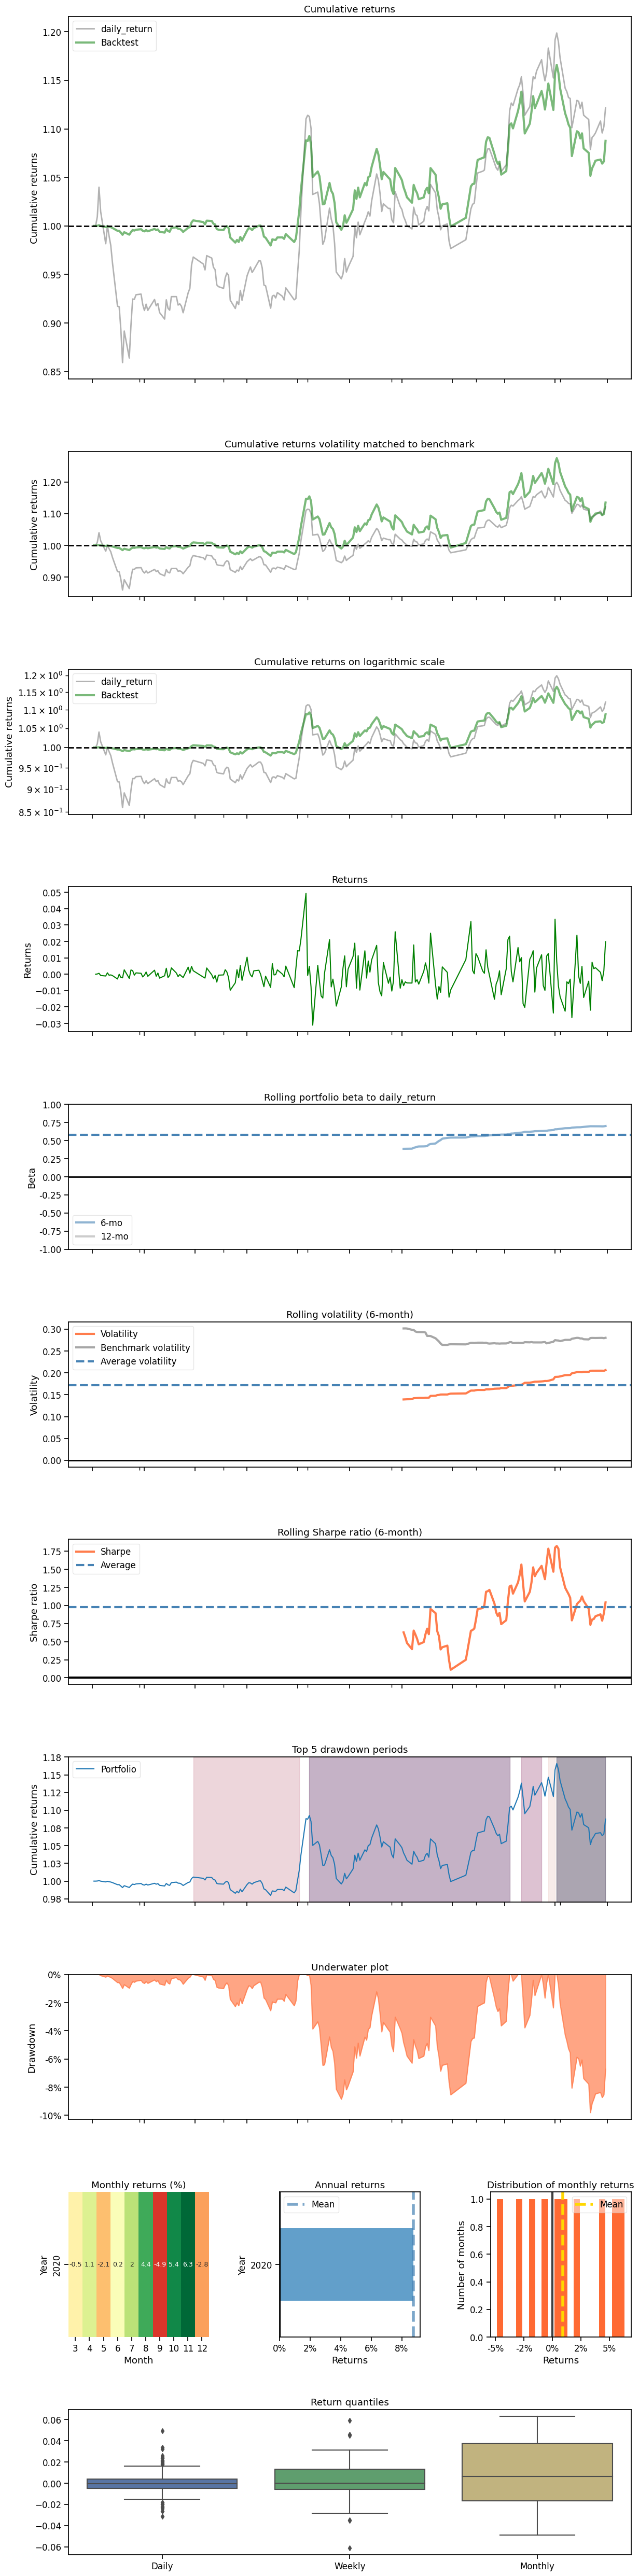

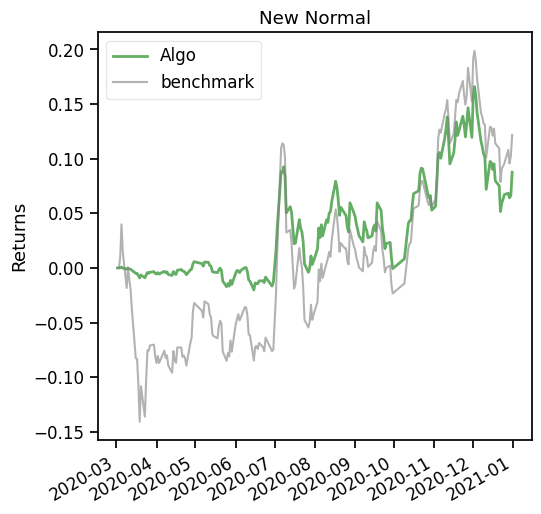

In [137]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print(df_account_value.loc[len(df_account_value)-1,'date'],df_account_value.loc[0,'date'])